In [1]:
import numpy as np
import arepo
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import h5py as h5

import re
import astropy.units as u
from scipy.spatial import cKDTree
from numba import njit, prange
from scipy.interpolate import interp1d
import matplotlib as mpl
from scipy.optimize import root_scalar
import glob
import agama

from pyMND.forcetree import construct_tree, force_treeevaluate_loop

from rbf.interpolate import KNearestRBFInterpolant
from sklearn.cluster import KMeans
from joblib import Parallel, delayed

time_conv = 977.79222167
G = 43018.7

In [8]:
def read_torques(name, lvl, idx):
    bpath = '/n/home01/abeane/starbar/plots/torques/data/torques_'
    
    fname = bpath + name + '-' + lvl + '/torques_' + name + '-' + lvl + '.' + str(idx) + '.hdf5'
    return h5.File(fname, mode='r')

def read_bar_angle(name, lvl):
    t = h5.File(bprop_path + 'bar_prop_' + name + '-' + lvl + '.hdf5', mode='r')
    out = t['bar_angle'][:]
    t.close()

    return out
    

In [12]:
bprop_path = '/n/home01/abeane/starbar/plots/bar_prop/data/'

def rotate_pos(pos, ang):

    Rmat = np.array([[np.cos(ang), -np.sin(ang), 0.0],
                     [np.sin(ang),  np.cos(ang), 0.0],
                     [0.0,         0.0,          1.0]])
    
    pos = np.swapaxes(pos, 0, 1)
    pos = np.matmul(Rmat, pos)
    pos = np.swapaxes(pos, 0, 1)
    
    return pos


In [13]:
idx_N = 800
idx_S = 200

t_N = read_torques('Nbody', 'lvl3', idx_N)
t_S = read_torques('phantom-vacuum-Sg20-Rc3.5', 'lvl3', idx_S)

In [14]:
bar_angle_S = read_bar_angle('phantom-vacuum-Sg20-Rc3.5', 'lvl3')

In [15]:
mass = t_S['parameters'].attrs['MassTable'][1]
tz_halo = np.cross(t_S['pos_halo'], t_S['acc_halo'])[:,2]
pos_halo = t_S['pos_halo'][:]

pos_halo = rotate_pos(pos_halo, -bar_angle_S[idx_S])


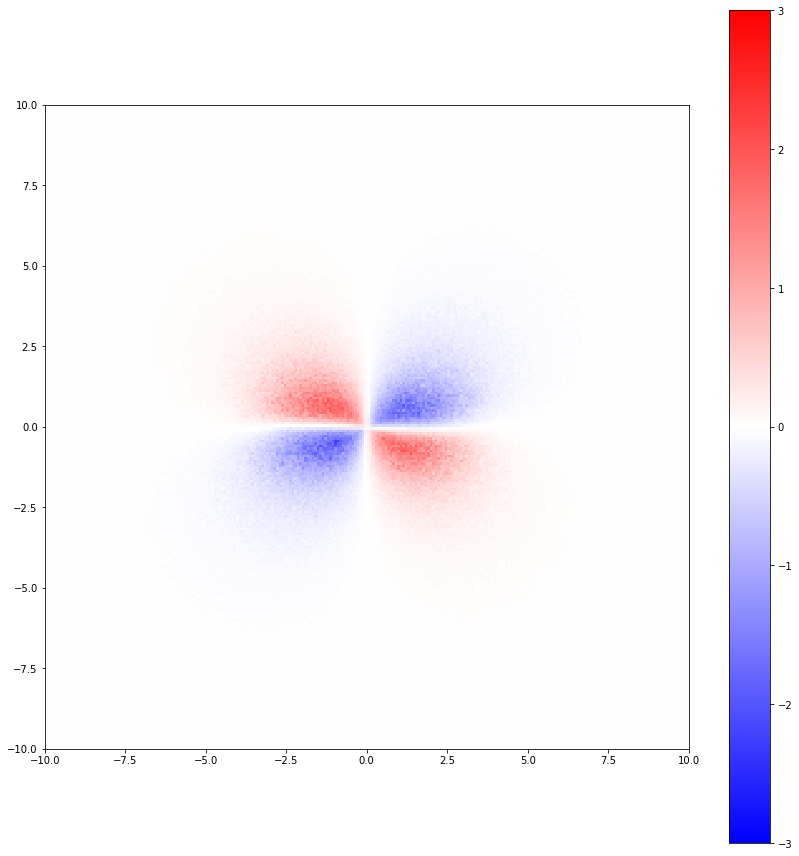

In [16]:
nres = 256

range_xy = [[-10, 10], [-10, 10]]

x = pos_halo[:,0]
y = pos_halo[:,1]
heatmap_xy, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy, weights=mass * tz_halo)

extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

im = ax.imshow(heatmap_xy.T, extent=extent, origin='lower', cmap='bwr', vmin=-3, vmax=3)#, vmin=-0.2, vmax=0.2)#, vmin=-50000, vmax=50000)
ax.set_aspect('equal')
fig.colorbar(im)

fig.tight_layout()

plt.show()


In [21]:
mass = t_S['gas_mass'][:]
tz_gas = np.cross(t_S['pos_gas'], t_S['acc_gas'])[:,2]
pos_gas = t_S['pos_gas'][:]

pos_gas = rotate_pos(pos_gas, -bar_angle_S[idx_S])


In [20]:
t_S.keys()

<KeysViewHDF5 ['acc_bar', 'acc_gas', 'acc_halo', 'acc_notbar', 'gas_mass', 'parameters', 'pos_bar', 'pos_gas', 'pos_halo', 'pos_notbar', 'total_torques']>

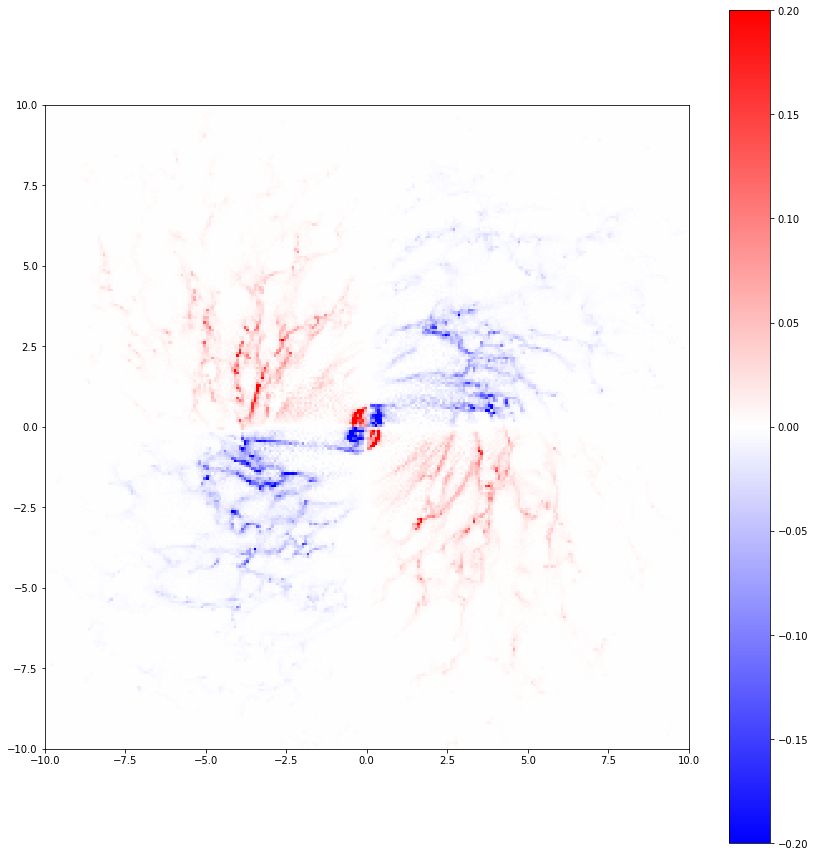

In [24]:
nres = 256

range_xy = [[-10, 10], [-10, 10]]

x = pos_gas[:,0]
y = pos_gas[:,1]
heatmap_xy, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy, weights=mass * tz_gas)

extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

im = ax.imshow(heatmap_xy.T, extent=extent, origin='lower', cmap='bwr', vmin=-0.2, vmax=0.2)#, vmin=-0.2, vmax=0.2)#, vmin=-50000, vmax=50000)
ax.set_aspect('equal')
fig.colorbar(im)

fig.tight_layout()

plt.show()


In [58]:
from scipy.spatial import cKDTree

nres = 4096
from numba import njit

tree = cKDTree(pos_gas)

@njit
def create_plot_pos(x, y, nres):
    plot_pos = np.zeros((nres*nres, 3))
    for i in range(len(x)):
        for j in range(len(y)):
            plot_pos[i*nres + j][0]=x[i][0]
            plot_pos[i*nres + j][1]=y[0][j]

    return plot_pos

x, y = np.meshgrid(np.linspace(-8, 8, nres), np.linspace(-8, 8, nres), indexing='ij')
plot_pos = create_plot_pos(x, y, nres)


In [59]:
%%time
_, key = tree.query(plot_pos)

CPU times: user 18.5 s, sys: 45.8 ms, total: 18.5 s
Wall time: 18.6 s


In [60]:
plot_torque = tz_gas[key]
plot_torque_map = np.reshape(plot_torque, (nres, nres))

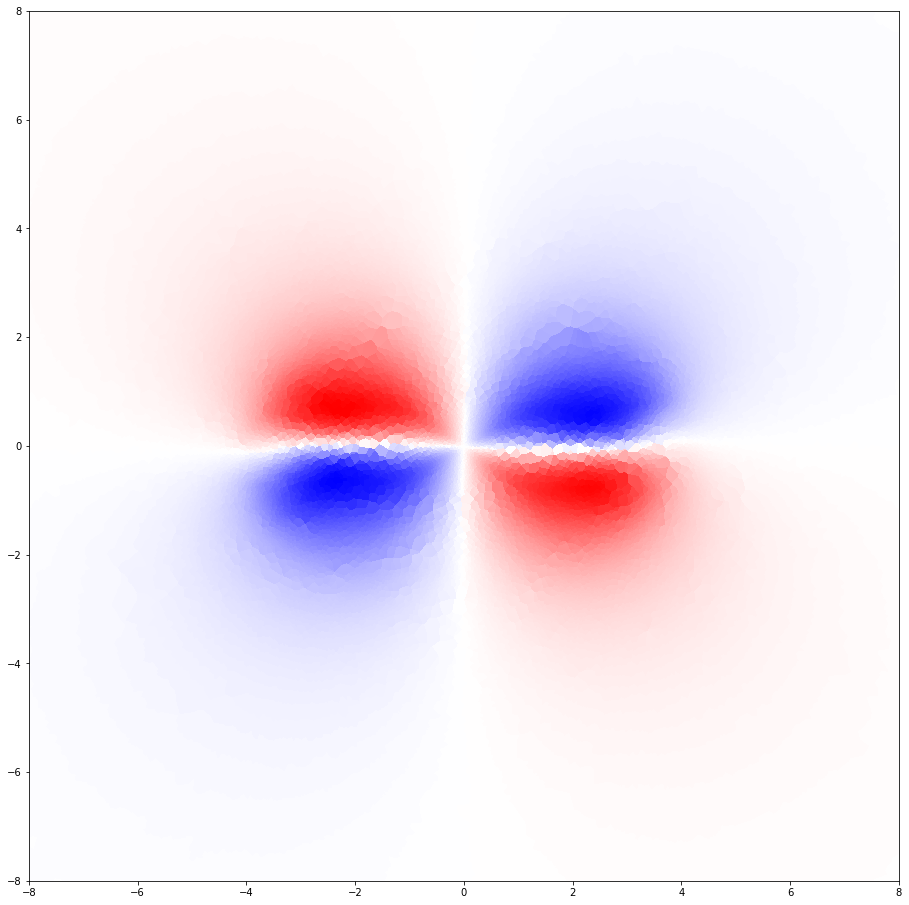

In [61]:


fig, ax = plt.subplots(1, 1, figsize=(16, 16))
extent = [-8, 8, -8, 8]
ax.imshow(plot_torque_map.T, extent=extent, origin='lower', cmap='bwr')
# ax.imshow(plot_SFR_map.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm(), cmap='Reds', alpha=1)
plt.show()

In [29]:
def get_R_tz(idx):
    t = read_torques('phantom-vacuum-Sg20-Rc3.5', 'lvl3', idx)
    mass = t['gas_mass'][:]
    tz_gas = np.cross(t['pos_gas'], t['acc_gas'])[:,2]
    pos_gas = t['pos_gas'][:]

    R = np.linalg.norm(pos_gas[:,:2], axis=1)
    return R, mass*tz_gas



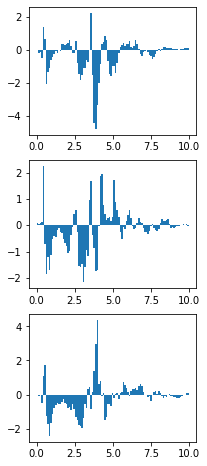

In [30]:


R0, tz0 = get_R_tz(200)
R1, tz1 = get_R_tz(210)
R2, tz2 = get_R_tz(220)

fig, ax = plt.subplots(3, 1, figsize=(3, 8))

ax[0].hist(R0, weights=tz0, bins=np.linspace(0, 10, 100))
ax[1].hist(R1, weights=tz1, bins=np.linspace(0, 10, 100))
ax[2].hist(R2, weights=tz2, bins=np.linspace(0, 10, 100))
plt.show()

In [49]:
Rlist = []
tzlist = []
idx_list = np.arange(175, 225)
for idx in tqdm(idx_list):
    R, tz = get_R_tz(idx)
    
    Rlist.append(R)
    tzlist.append(tz*len(R))
    
Rlist = np.concatenate(Rlist)
tzlist = np.concatenate(tzlist)/len(Rlist)




A Jupyter Widget

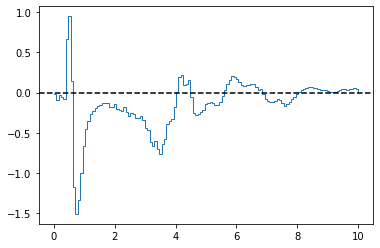

In [50]:
fig, ax = plt.subplots(1, 1)

ax.hist(Rlist, weights=tzlist, histtype='step', bins=np.linspace(0, 10, 128))
ax.axhline(0, c='k', ls='dashed')
# ax.axvline(220/40)
plt.show()